In [34]:
#import the librearies
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [35]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split as split

from keras.layers import Input
from keras.models import Model

from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray

np.random.seed(1120)

In [36]:
import yfinance as yf
#data = yf.download("AAPL", start="2017-01-01", end="2017-04-30")
#show the data
aapl=yf.Ticker('AAPL')
df=aapl.history(start="2010-01-01",  end="2023-02-03")
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-01-27 00:00:00-05:00,143.160004,147.229996,143.080002,145.929993,70492800,0.0,0.0
2023-01-30 00:00:00-05:00,144.960007,145.550003,142.850006,143.000000,64015300,0.0,0.0
2023-01-31 00:00:00-05:00,142.699997,144.339996,142.279999,144.289993,65874500,0.0,0.0
2023-02-01 00:00:00-05:00,143.970001,146.610001,141.320007,145.429993,77663600,0.0,0.0
2023-02-02 00:00:00-05:00,148.899994,151.179993,148.169998,150.820007,118339000,0.0,0.0


In [37]:
#create a new dataframe with only the close column
data=df.filter(['Close'])
#convert the dataframe to numpy array
dataset=data.values
#Get the number of rows to train the model on
training_data_len=math.ceil(len(dataset)*.8)
training_data_len

2636

In [38]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)
scaled_data.shape

(3294, 1)

In [39]:
#x_train,y_train=np.array(x_train),np.array(y_train)
#x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
scaled_data=np.array(scaled_data)
scaled_data=np.reshape(scaled_data,(len(scaled_data),1))
#data = np.reshape(np.array(data['wp1']),(len(data['wp1']),1))

In [40]:
scaled_data.shape

(3294, 1)

In [41]:
#Create the training dataset
#Create the scaled training dataset
train_data=scaled_data[0:training_data_len]
test_data=scaled_data[training_data_len:]

In [42]:
train_data.shape

(2636, 1)

In [43]:
def prepare_dataset(data, window_size):
    X, Y = np.empty((0,window_size)), np.empty((0))
    for i in range(len(data)-window_size-1):
        X = np.vstack([X,data[i:(i + window_size),0]])
        Y = np.append(Y,data[i + window_size,0])   
    X = np.reshape(X,(len(X),window_size,1))
    Y = np.reshape(Y,(len(Y),1))
    return X, Y

def train_evaluate(ga_individual_solution):   
    # Decode GA solution to integer for window_size and num_units
    window_size_bits = BitArray(ga_individual_solution[0:6])
    num_units_bits = BitArray(ga_individual_solution[6:]) 
    window_size = window_size_bits.uint
    num_units = num_units_bits.uint
    print('\nWindow Size: ', window_size, ', Num of Units: ', num_units)
    
    # Return fitness score of 100 if window_size or num_unit is zero
    if window_size == 0 or num_units == 0:
        return 100, 
    
    # Segment the train_data based on new window_size; split into train and validation (80/20)
    X,Y = prepare_dataset(train_data,window_size)
    X_train, X_val, y_train, y_val = split(X, Y, test_size = 0.20, random_state = 1120)
    
    # Train LSTM model and predict on validation set
    inputs = Input(shape=(window_size,1))
    x = LSTM(num_units, input_shape=(window_size,1))(inputs)
    predictions = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(optimizer='adam',loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=5, batch_size=10,shuffle=True)
    y_pred = model.predict(X_val)
    
    # Calculate the RMSE score as fitness score for GA
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print('Validation RMSE: ', rmse,'\n')
    
    return rmse,

In [44]:
population_size = 4
num_generations = 4
gene_length = 10

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, 
n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n = population_size)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, 
ngen = num_generations, verbose = False)

C:\Users\HOME\AppData\Roaming\Python\Python39\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\HOME\AppData\Roaming\Python\Python39\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



Window Size:  36 , Num of Units:  2
Epoch 1/5
208/208 [==============================] - 3s 7ms/step - loss: 0.0114
Epoch 2/5
208/208 [==============================] - 1s 7ms/step - loss: 0.0011
Epoch 3/5
208/208 [==============================] - 2s 7ms/step - loss: 2.1661e-04
Epoch 4/5
208/208 [==============================] - 1s 7ms/step - loss: 1.6231e-04
Epoch 5/5
17/17 [==============================] - 0s 3ms/step
Validation RMSE:  0.01144151459315955 


Window Size:  56 , Num of Units:  8
Epoch 1/5
207/207 [==============================] - 4s 11ms/step - loss: 3.3588e-04
Epoch 2/5
207/207 [==============================] - 2s 11ms/step - loss: 5.5421e-05
Epoch 3/5
207/207 [==============================] - 2s 11ms/step - loss: 5.1320e-05
Epoch 4/5
207/207 [==============================] - 2s 11ms/step - loss: 4.6285e-05
Epoch 5/5
17/17 [==============================] - 0s 3ms/step
Validation RMSE:  0.006820186766102151 


Window Size:  60 , Num of Units:  9
Epoch 1/5
206/

17/17 [==============================] - 0s 4ms/step
Validation RMSE:  0.009219628015152533 


Window Size:  22 , Num of Units:  3
Epoch 1/5
209/209 [==============================] - 2s 3ms/step - loss: 7.4546e-04
Epoch 2/5
209/209 [==============================] - 1s 3ms/step - loss: 6.0559e-05
Epoch 3/5
209/209 [==============================] - 1s 3ms/step - loss: 5.7217e-05
Epoch 4/5
209/209 [==============================] - 1s 3ms/step - loss: 5.4520e-05
Epoch 5/5
17/17 [==============================] - 0s 3ms/step
Validation RMSE:  0.007346403778393782 



In [45]:
# Print top N solutions - (1st only, for now)
best_individuals = tools.selBest(population,k = 1)
best_window_size = None
best_num_units = None

for bi in best_individuals:
    window_size_bits = BitArray(bi[0:6])
    num_units_bits = BitArray(bi[6:]) 
    best_window_size = window_size_bits.uint
    best_num_units = num_units_bits.uint
    print('\nWindow Size: ', best_window_size, ', Num of Units: ', best_num_units)


Window Size:  53 , Num of Units:  9


In [46]:
#create a new dataframe with only the close column
data=df.filter(['Close'])
#convert the dataframe to numpy array
dataset=data.values
#Get the number of rows to train the model on
training_data_len=math.ceil(len(dataset)*.8)
training_data_len
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)
scaled_data.shape
#Create the training dataset
#Create the scaled training dataset
train_data=scaled_data[0:training_data_len,:]
#Split the data into x_train and y_train data sets
x_train=[]
y_train=[]
for i in range(best_window_size,len(train_data)):
    x_train.append(train_data[i-best_window_size:i,0])
    y_train.append(train_data[i,0])
#convert the x_train and y_train to numpy arrays
x_train,y_train=np.array(x_train),np.array(y_train)
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
#Create the testing data set
#Create a new array containing scaled values from index 2101 to 2701
test_data=scaled_data[training_data_len-best_window_size:,:]
#Create the data sets x_test and y_test
x_test=[]
y_test=dataset[training_data_len:,:]
for i in range(best_window_size,len(test_data)):
    x_test.append(test_data[i-best_window_size:i,0])
#Convert the data to a numpy array
x_test=np.array(x_test)
#reshape the data
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [47]:
# Train the model using best configuration on complete training set 
#and make predictions on the test set
#X_train,y_train = prepare_dataset(train_data,best_window_size)
#X_test, y_test = prepare_dataset(test_data,best_window_size)

inputs = Input(shape=(best_window_size,1))
x = LSTM(best_num_units, input_shape=(best_window_size,1))(inputs)
predictions = Dense(1, activation='linear')(x)
model = Model(inputs = inputs, outputs = predictions)
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(x_train, y_train, epochs=5, batch_size=10,shuffle=True)
y_pred = model.predict(x_test)

#rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#print('Test RMSE: ', rmse)

Epoch 1/5
259/259 [==============================] - 4s 11ms/step - loss: 3.1711e-04
Epoch 2/5
259/259 [==============================] - 3s 11ms/step - loss: 5.1326e-05
Epoch 3/5
259/259 [==============================] - 3s 12ms/step - loss: 4.4635e-05
Epoch 4/5
259/259 [==============================] - 3s 11ms/step - loss: 4.0068e-05
Epoch 5/5
21/21 [==============================] - 0s 4ms/step


In [48]:
predictions=y_pred
predictions=scaler.inverse_transform(predictions)
rmse=np.sqrt(np.mean(predictions-y_test)**2)
rmse

2.225153091106009

C:\Users\HOME\AppData\Local\Temp\ipykernel_25972\1480295259.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Prediction']=predictions


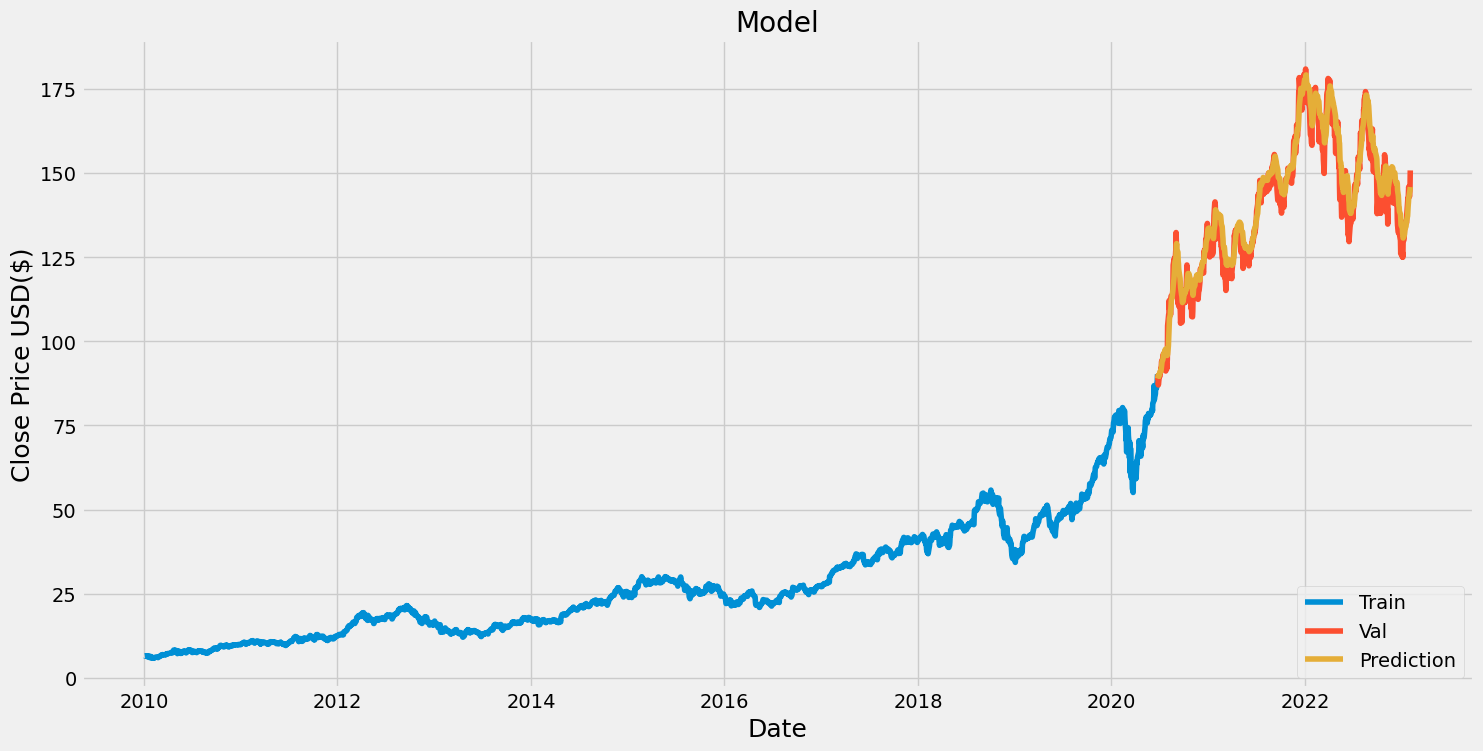

In [49]:
#Plot the data
train=data[:training_data_len]
valid=data[training_data_len:]
valid['Prediction']=predictions
#visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Prediction']])
plt.legend(['Train','Val','Prediction'],loc='lower right')
plt.show()

In [50]:
start = pd.to_datetime(['2007-01-01']).astype(int)[0]//10**9 # convert to unix timestamp.
end = pd.to_datetime(['2023-02-02']).astype(int)[0]//10**9 # convert to unix timestamp.
stock_ticker='AAPL'
url = 'https://query1.finance.yahoo.com/v7/finance/download/' + stock_ticker + '?period1=' + str(start) + '&period2=' + str(end) + '&interval=1d&events=history'
#Get the quote
apple_quote=aapl.history(start="2010-01-01",  end="2023-02-03")
#Create a new data frame
new_df=apple_quote.filter(['Close'])
#Get the last 60 day closing price value and convert dataframe to an array
last_60_days=new_df[-60:].values
#Scale the data
last_60_days_scaled=scaler.transform(last_60_days)
#create an empty list
X_test=[]
#Append the past 60 days
X_test.append(last_60_days_scaled)
#convert the x_test data set to numpy array
X_test=np.array(X_test)
#Reshape the data
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
#Get the predicted scale price
pred_price=model.predict(X_test)
#Undo the scaling
pred_price=scaler.inverse_transform(pred_price)
print(pred_price)

1/1 [==============================] - 0s 274ms/step
[[147.87599]]
